# Basic Molecular Dynamics Techniques
## NVE MD of a Lennard-Jones system
At the end of this notebook, there is a script for MD of a Lennard-Jones fluid in the $NVE$ ensemble.

1. In the code below, the function `lennard_jones_molecular_dynamics` should implement the time integration of an MD trajectory.
The time integration is missing!
Complete the code with your favourite integrator.

2. How is one able to control the temperature in NVE MD?
After all, the total energy of the system should be constant (not the temperature).

verlet integrator can save the total energy of the system. so the temperature will oscillate.

3. To test the energy drift $\Delta E$ of the numerical integration algorithm for a given time step $\Delta t$ after $N$ integration
steps, one usually computes
\begin{equation}
\Delta E\left(\Delta t\right) = \frac{1}{N} \sum_{i=1}^{i=N} \left|
\frac{E\left(0\right) - E\left(i\Delta t\right)}{E\left(0\right)}
\right|
\end{equation}
In this equation, $E\left(t\right)$ is the total energy (kinetic+potential) of the system at time $t$.

Compute $\Delta E$ and make a plot of $\Delta E$ as a function of the time step.
To maintain a certain energy drift, how does the time step have to change as a function of the temperature and density?

Energy drift at timestep 0.001: 3.577385538365515e-05
Energy drift at timestep 0.005: 0.00038057391739995623
Energy drift at timestep 0.01: 0.0009980059515345087


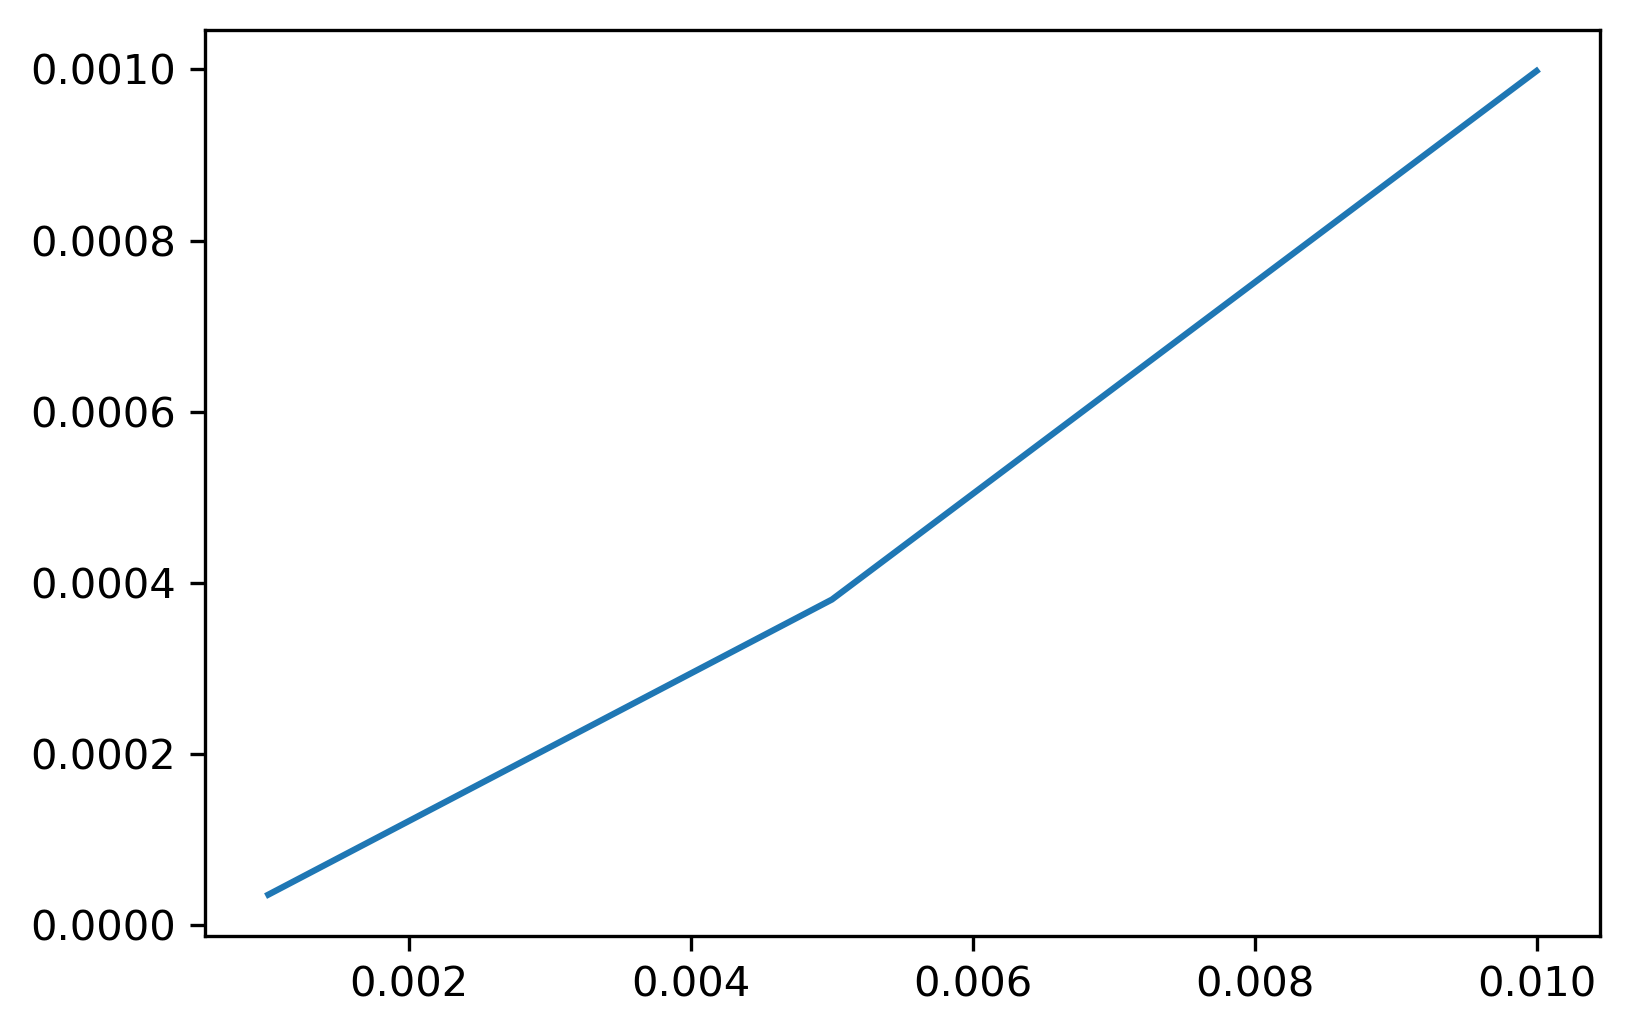

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"  ] = 300

timesteps = [0.001,0.005,0.01]
steps_per_sample = 100
energy_drifts = np.zeros(len(timesteps))
for timestep in timesteps:
    energy_drift = 0
    # calculating the energy drift after the MD
    with open(f"md_simulation_data_timestep{timestep}.pkl", 'rb') as p:
        samples = pickle.load(p)

    for i in range(1, len(samples)):
        energy_drift += np.abs((samples[i]['energy'] - samples[0]['energy'])/ samples[0]['energy']) 
    # calculate the average energy drift
    energy_drift /= len(samples) - 1
    # print the result
    print(f"Energy drift at timestep {timestep}: {energy_drift}")

    # store the energy drift for this timestep
    energy_drifts[timesteps.index(timestep)] = energy_drift

plt.plot(timesteps, energy_drifts)


4.  An important quantity of a liquid or gas is the so-called self
diffusivity $D$. There are two methods to calculate $D$:
    1. by integrating the velocity autocorrelation function:

\begin{align}
D &= \frac{1}{3}\int_{0}^{\infty} \left\langle {\bf
v}\left(t\right)\cdot {\bf v}\left(t+t^{'}\right) \right\rangle
dt^{'}\nonumber\\ 
&= \frac{\int_{0}^{\infty} \sum_{i=1}^{i=N}
\left\langle{\bf v}\left(i,t\right)\cdot{\bf v}\left(i,t +
t^{'}\right)\right\rangle dt^{'}}{3N}
\end{align}

in which $N$ is the number of particles and ${\bf v}\left(i,t\right)$
is the velocity of particle $i$ at time $t$. One should choose $t$ in
such a way that independent time origins are taken, *i.e.* $t =
ia\Delta t$, $i=1,2, \cdots , \infty$ and $\left\langle {\bf
v}\left(t\right)\cdot{\bf v}\left(t+a\Delta t\right)\right\rangle
\approx {\bf 0}$ (why?).

    B. by calculating the mean square displacement:
    
\begin{equation}
D = \lim_{t^{'} \rightarrow \infty} \frac{\left\langle \left|{\bf
x}\left(t + t^{'}\right) - {\bf x} \left(t\right)\right|^{2}
\right\rangle}{6t^{'}}
\end{equation}

One should be very careful with the mean square displacement calculation when particles are always translated back to the central box---why?

Implement functions that calculate both MSD and VACF, and plot the both for some system parameters.
Why is it important to use only independent time origins for the calculation of the mean square displacement and the velocity autocorrelation function?
What is the unit of $D$ in SI units?
How can one transform $D$ into dimensionless units?

In [23]:
# python version code
def msd_python(xs:np.ndarray):
    """
    xs: np.ndarray [N_frames,N_atoms,3]
    """
    # calculate the mean square displacement
    msd_data = np.zeros(xs.shape[0])
    for i in range(xs.shape[0]):
        msd_data[i] = np.mean(np.sum((xs[i] - xs[0])**2, axis=1))
    return msd_data
        

(500, 108, 3)


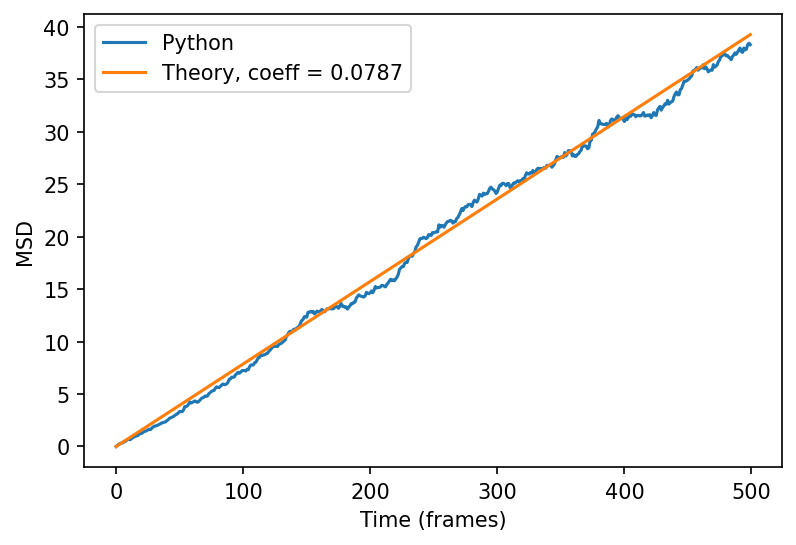

In [34]:
with open("md_simulation_data_timestep0.005.pkl", 'rb') as p:
    samples = pickle.load(p)

xs = np.array([sample['xs'] for sample in samples])
print(xs.shape)

msd_data = msd_python(xs)
plt.plot(msd_data, label='Python')
# theory line : y = 6Dt, timestep*samples_per_timestep
# y= 6*0.005*100*t
# polyfit
coeff = np.polyfit(np.arange(len(msd_data)), msd_data, 1)
plt.plot(coeff[0]*np.arange(len(msd_data)), label='Theory, coeff = %.4f' % coeff[0])
plt.xlabel('Time (frames)')
plt.ylabel('MSD')
plt.legend()

In [29]:
import numpy as np
from scipy.integrate import simps # 使用辛普森法则进行数值积分

def calculate_vacf(samples, max_lag_steps):
    """
    计算速度自相关函数 (VACF)。

    Args:
        samples (list): 包含轨迹帧信息的字典列表。
                        每个字典应包含 'vs' (速度数组) 和 'timestep'。
        max_lag_steps (int): 要计算 VACF 的最大时间延迟步数。

    Returns:
        tuple: (vacf, time_lags)
               vacf (np.ndarray): 计算得到的 VACF 值。
               time_lags (np.ndarray): 对应的时间延迟。
    """
    if not samples:
        return np.array([]), np.array([])

    num_samples = len(samples)
    if num_samples <= max_lag_steps:
        raise ValueError("需要比 max_lag_steps 更多的样本来计算 VACF。")

    velocities = np.array([sample['vs'] for sample in samples]) # (num_samples, num_particles, dimensions)
    num_particles = velocities.shape[1]
    dimensions = velocities.shape[2]
    dt = 0.005 *100
    #dt = samples[0]['timestep'] * samples[0]['steps_per_sample'] # 样本之间的时间步长

    vacf = np.zeros(max_lag_steps)
    num_origins = num_samples - max_lag_steps # 可用的时间原点数量

    # 对所有时间原点 t (由索引 i 代表) 进行平均
    for lag_step in range(max_lag_steps): # lag_step 代表 t' / dt
        vacf_at_lag = 0.0
        for i in range(num_origins): # 遍历所有可能的时间原点
            # 计算 v(t) · v(t + t')，t = i*dt, t' = lag_step*dt
            # 在所有粒子上求和并平均
            dot_product = np.sum(velocities[i] * velocities[i + lag_step])
            vacf_at_lag += dot_product

        vacf[lag_step] = vacf_at_lag / num_origins

    # 除以粒子数 N 和维度 d (通常是 3，但这里我们直接用点积，所以不需要除以 d)
    # 注意：公式 D = 1/3 * integral(...) 中的 1/3 因子是针对三维系统的。
    # VACF 本身通常定义为 <v(0)·v(t)> / <v(0)·v(0)> 或直接 <v(t)·v(t+t')>。
    # 为了与扩散系数公式一致，我们这里计算的是 sum_i <v_i(t)·v_i(t+t')>
    # 最后计算 D 时再除以 3N。
    # 然而，更常见的做法是直接计算 <v(t)·v(t+t')> = 1/N * sum_i <v_i(t)·v_i(t+t')>
    vacf /= num_particles

    time_lags = np.arange(max_lag_steps) * dt
    return vacf, time_lags

def calculate_diffusion_coefficient_from_vacf(vacf, time_lags):
    """
    通过对 VACF 积分来计算扩散系数 D。

    Args:
        vacf (np.ndarray): 速度自相关函数的值。
        time_lags (np.ndarray): 对应的时间延迟。

    Returns:
        float: 计算得到的扩散系数 D。
    """
    if len(vacf) < 2 or len(time_lags) < 2:
        return 0.0 # 无法积分

    # 使用辛普森法则进行数值积分
    # D = (1/3) * integral(vacf dt') from 0 to infinity
    # 积分的上限实际上是 max_lag_steps * dt
    integral = simps(vacf, time_lags)

    # 扩散系数 D (假设为三维系统)
    D = integral / 3.0
    return D

In [30]:
with open("md_simulation_data_timestep0.005.pkl", 'rb') as p:
    samples = pickle.load(p)

vacf , time_lags = calculate_vacf(samples, max_lag_steps=100)

D = calculate_diffusion_coefficient_from_vacf(vacf, time_lags)
print(f"扩散系数 D: {D:.4f} nm^2/ps")

扩散系数 D: 0.1205 nm^2/ps


In [ ]:
xs = np.array([sample['xs'] for sample in samples]) # (num_samples, num_particles, dimensions)

msd_values = np.zeros(steps_per_sample)
msd = np.zeros(steps_per_sample)

TypeError: list indices must be integers or slices, not str

5. For Lennard-Jones liquids, Naghizadeh and Rice report the following equation for the self diffusivity (dimensionless units,
$T^* <1.0$ and $p^* <3.0$)
\begin{equation}
{\rm ^{\rm 10}log}\left(D^* \right) = 0.05 + 0.07p^* - \frac{1.04 +
0.1p^*}{T^*}
\end{equation}
Try to confirm this equation with simulations. 

In [ ]:
temperature =1.5

def calculate_pressure(samples,density, temperature):
    # calculate the pressure, first part is ideal gas pressure
    ideal_gas_pressure = density * temperature
    # second part is virial pressure, calculate the virial pressure from g(r) radial distribution function
    

6. Instead of calculating the average potential $\left\langle U \right\rangle$ directly, one can use the radial distribution function
$g\left(r\right)$.
Derive an expression for $\left\langle U \right\rangle$ using $g\left(r\right)$.
Compare this calculation with a direct calculation of the average energy.
A similar method can be used to compute the average pressure.

# measurements for U


In [ ]:
!pip install --upgrade cython

In [3]:
%load_ext Cython

In [4]:
%%cython

from cython.cimports.libc.math import sqrt, rint, INFINITY, floor, ceil
import cython
import numpy as np


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def lennard_jones_energy_virial(xs: cython.double[:, ::1], box_length: cython.double, rcut: cython.double) -> cython.tuple[float, float]:
    """ Compute the energy and virial of a system of Lennard Jones particles. """
    particles: cython.int = xs.shape[0]
    dimensions: cython.int = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    energy = 0.0
    virial = 0.0

    rcut2 = rcut * rcut
    rcut6 = 1.0 / rcut2
    rcut6 *= rcut6 * rcut6
    ecut = 4.0 * rcut6 * (rcut6 - 1)

    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rijd = xs[i, d] - xs[j, d]
                rijd -= rint(rijd / box_length) * box_length
                r2 += rijd * rijd
            if r2 > rcut2:
                continue
            r6 = 1 / r2
            r6 *= r6 * r6
            energy += 4.0 * r6 * (r6 - 1.0) - ecut
            virial += 48.0 * r6 * (r6 - 0.5)
    return energy, virial


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def lennard_jones_force(xs: cython.double[:, ::1], box_length: cython.double, rcut: cython.double) -> np.ndarray:
    """ Compute the forces on a system of Lennard-Jones particles. """
    particles: cython.int = xs.shape[0]
    dimensions: cython.int = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    rcut2 = rcut * rcut
    fs: cython.double[:, ::1] = np.zeros_like(xs)
    rij: cython.double[::1] = np.zeros(dimensions)
    
    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rij[d] = xs[i, d] - xs[j, d]
                rij[d] -= rint(rij[d] / box_length) * box_length
                r2 += rij[d] * rij[d]
            if r2 > rcut2:
                continue
            r6 = 1.0 / r2
            r6 *= r6 * r6
            fij = 48.0 * r6 * (r6 - 0.5) / r2
            for d in range(dimensions):
                fs[i, d] += fij * rij[d]
                fs[j, d] -= fij * rij[d]
    return np.array(fs)


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def rdf(xs: cython.double[:, ::1], box_length: cython.double, rcut: cython.double, dr: cython.double) -> cython.double[::1]:
    """ Accumulate the non-normalised radial distribution function """
    particles: cython.int = xs.shape[0]
    dimensions: cython.int = xs.shape[1]
    i: cython.Py_ssize_t
    j: cython.Py_ssize_t
    d: cython.Py_ssize_t
    b: cython.Py_ssize_t
    bins = <int>ceil(sqrt(3.0)*box_length / 2.0 / dr)
    histogram: cython.double[::1] = np.zeros(bins)
    bin_edges = np.arange(0, bins + 1) * dr
    density = particles / box_length ** 3
    factor: cython.double[::1] = 4.0 / 3.0 * np.pi * (bin_edges[1:bins + 1] ** 3 - bin_edges[0:bins] ** 3) * density * particles

    for i in range(particles):
        for j in range(i + 1, particles):
            r2 = 0.0
            for d in range(dimensions):
                rijd = xs[i, d] - xs[j, d]
                rijd -= rint(rijd / box_length) * box_length
                r2 += rijd * rijd
            r = sqrt(r2)
            b = <Py_ssize_t>floor(r / dr)
            histogram[b] += 2.0
            
    return np.array(histogram)/factor

In [3]:
import numpy as np
from scipy.optimize import minimize


def get_initial_configuration(particles, dimensions, box_length, rcut):
    """ use scipy functions to minimize the energy of a random configuration """
    
    def func(xs):
        return lennard_jones_energy_virial(xs.reshape(particles, dimensions), box_length, rcut)[0]
    def jac(xs):
        return -lennard_jones_force(xs.reshape(particles, dimensions), box_length, rcut).reshape(-1)

    xs = np.random.rand(particles * dimensions) * box_length
    ret = minimize(func, x0=xs, jac=jac)
    return ret.x.reshape(particles, dimensions)

In [5]:
def sample(xs: np.ndarray, vs: np.ndarray, fs: np.ndarray, box_length: float, rcut: float, dr: float, beta: float, samples:[dict] = None) -> [dict]:
    """
    Accumulate samples from a trajectory frame.
    You can calculate anything you like and save it for later.
    """
    if samples is None:
        samples = []
        
    particles = xs.shape[0]
    pe, virial = lennard_jones_energy_virial(xs, box_length, rcut)
    ke = 0.5 * (vs ** 2).sum()
    samples.append({
        'xs': xs.copy(),
        'vs': vs.copy(),
        'fs': fs.copy(),
        'pe': pe,
        'ke': ke,
        'energy': pe + ke,
        'box_length': box_length,
        'rcut': rcut,
        'dr': dr,
        'beta': beta,
        'rdf': rdf(xs, box_length, rcut, dr).copy()
    })
    return samples


def lennard_jones_molecular_dynamics(
    xs: np.ndarray,
    vs: np.ndarray,
    box_length: float,
    rcut: float,
    dr: float,  # for rdf
    beta: float,  # for other rdf
    timestep: float,
    steps: int,
    steps_per_sample: int
):
    """
    Run some NVE MD.

    xs, vs, and fs are the coordinates, velocities, and forces, respectively.    
    """
    samples = None
    
    fs = lennard_jones_force(xs, box_length, rcut)

    for step in range(steps):
        # integrate, use velocity Verlet
        xs[:] += vs * timestep + 0.5 * fs * timestep * timestep
        fs_old = fs.copy()
        fs[:] = lennard_jones_force(xs, box_length, rcut)
        vs[:] += 0.5 * (fs + fs_old) * timestep

        # half step velocity Verlet
        
        if step % steps_per_sample == 0:
            samples = sample(xs, vs, fs, box_length, rcut, dr, beta, samples)
        if step % 1000 == 0:
            print(f"lennard_jones_molecular_dynamics> step: {step}")
    
    return samples


In [ ]:
from itertools import product
import pickle
import numpy as np


def main():
    """
    Run NVE MD of a Lennard-Jones system.
    
    Saves sampled data to "md_simulation_data.pkl"
    """
    
    # set up the system
    particles = 108
    dimensions = 3

    rcut = 2.5
    temperature = 1.50
    beta = 1 / temperature
    timestep = 0.005
    steps = 50000
    steps_per_sample = 100
    equilibration_samples = 0
    density = 0.8442
    box_length = (particles / density) ** (1 / dimensions)
    dr = 0.005

    if box_length < 2 * rcut:
        raise ValueError("rcut too large for this box (2 * rcut = {2*rcut} > {box_length} = box_length)")

    # initial positions & velocities
    xs = get_initial_configuration(particles, dimensions, box_length, rcut)
    vs = np.random.randn(xs.size).reshape(xs.shape)
    vs -= vs.mean(0)
    vs *= np.sqrt(temperature * (3 * particles - 3)/(vs ** 2).sum())

    # equilibration, run and reset the teperature
    

    # production
    samples = lennard_jones_molecular_dynamics(
        xs, vs, box_length, rcut, dr, beta, timestep, steps, steps_per_sample
    )

    with open(f"md_simulation_data_timestep{timestep}.pkl", 'wb') as p:
        pickle.dump(samples, p)


if __name__ == "__main__":
    main()
    

lennard_jones_molecular_dynamics> step: 0
lennard_jones_molecular_dynamics> step: 1000
lennard_jones_molecular_dynamics> step: 2000
lennard_jones_molecular_dynamics> step: 3000
lennard_jones_molecular_dynamics> step: 4000
lennard_jones_molecular_dynamics> step: 5000
lennard_jones_molecular_dynamics> step: 6000
lennard_jones_molecular_dynamics> step: 7000
lennard_jones_molecular_dynamics> step: 8000
lennard_jones_molecular_dynamics> step: 9000
lennard_jones_molecular_dynamics> step: 10000
lennard_jones_molecular_dynamics> step: 11000
lennard_jones_molecular_dynamics> step: 12000
lennard_jones_molecular_dynamics> step: 13000
lennard_jones_molecular_dynamics> step: 14000
lennard_jones_molecular_dynamics> step: 15000
lennard_jones_molecular_dynamics> step: 16000
lennard_jones_molecular_dynamics> step: 17000
lennard_jones_molecular_dynamics> step: 18000
lennard_jones_molecular_dynamics> step: 19000
lennard_jones_molecular_dynamics> step: 20000
lennard_jones_molecular_dynamics> step: 21000
l

max energy, min energy, mean energy -442.8361952987666 -442.8607751484327 -442.8449639967821


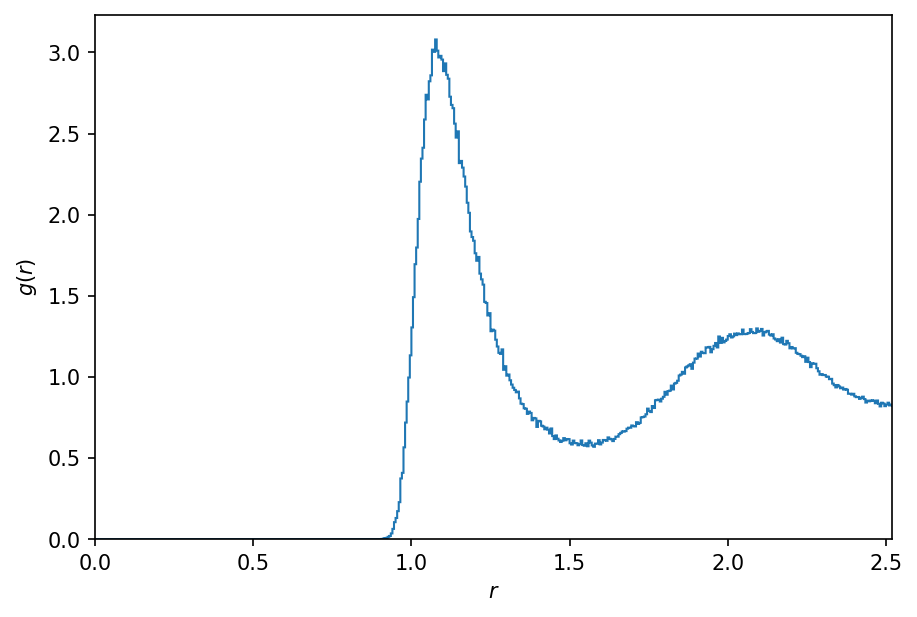

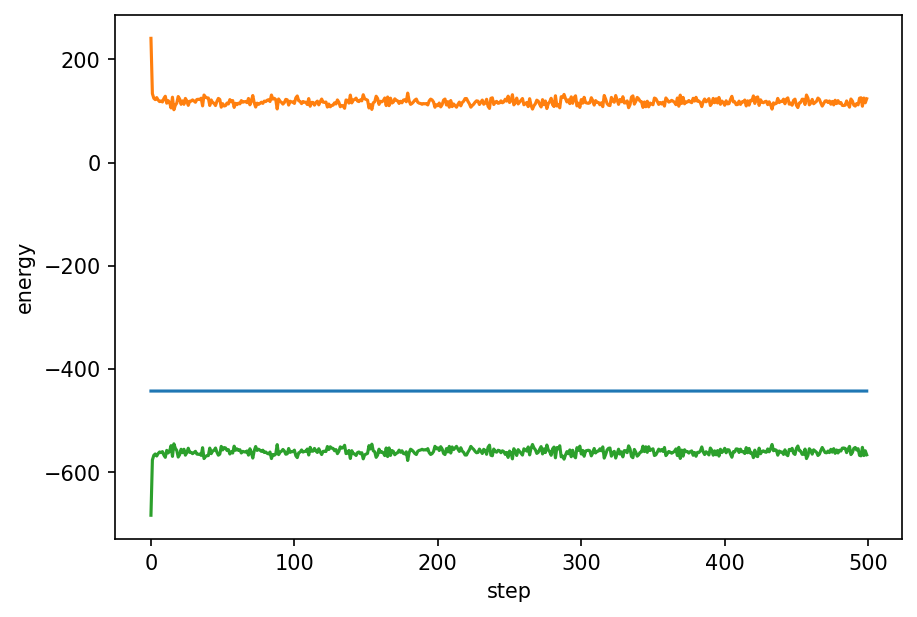

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

def main():
    """
    Analyse a Lennard-Jones NVE MD trajectory.
    
    Reads data from "md_simulation_data.pkl"
    """
    # load the data
    timestep = 0.001
    
    with open(f"md_simulation_data_timestep{timestep}.pkl", 'rb') as p:
        samples = pickle.load(p)

    # do some analysis

    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,4))

    dr = samples[0]['dr']
    box_length = samples[0]['box_length']
    
    rdfs = np.array([sample["rdf"] for sample in samples]).mean(0)
    bin_edges = np.arange(0, np.sqrt(3) * box_length / 2 + dr, dr)

    ax.stairs(rdfs, bin_edges)
    ax.set_xlim(0, box_length/2)
    ax.set_xlabel("$r$")
    ax.set_ylabel("$g{(r)}$")

    # plot the total energy
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,4))
    energies = np.array([sample["energy"] for sample in samples])
    # pe = np.array([sample["pe"] for sample in samples])
    # ke = np.array([sample["ke"] for sample in samples])
    ax.plot(energies)
    # ax.plot(ke)
    # ax.plot(pe)
    print("max energy, min energy, mean energy", energies.max(), energies.min(), energies.mean())
    ax.set_xlabel("step")
    ax.set_ylabel("energy")


if __name__=="__main__":
    main()